# Maintenance Prédictive (Détection de Pannes)

savoir anticiper une panne grâce aux capteurs permet d'économiser des millions en évitant l'arrêt total des machine

dataset: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Phase 1 : Scrub & Explore (Nettoyage et Analyse)

In [2]:
# 1. chargement des données
df = pd.read_csv('/content/predictive_maintenance.csv')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [3]:
# 2 Voir les colonnes et leurs types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [4]:
# 1. On simplifie les noms de colonnes pour plus de facilité
df.columns = ['UDI', 'ID', 'type', 'Air_Temp', 'Process_temp', 'Speed', 'Torque', 'Tool_Wear', 'Target', 'Failure_Type']

In [5]:
# 2. Analyse de l'équilibre des classes
# Très important : Dans la vraie vie, il y a beaucoup plus de "Normal" que de "Panne"
df['Target'].value_counts(normalize=True)

,proportion
Target,
0,0.9661
1,0.0339


Interpretation

environ 96,6 % des instances sont « Aucune défaillance » ($Target = 0$), tandis que seulement 3,4 % représentent un échec réel ($Target = 1$)

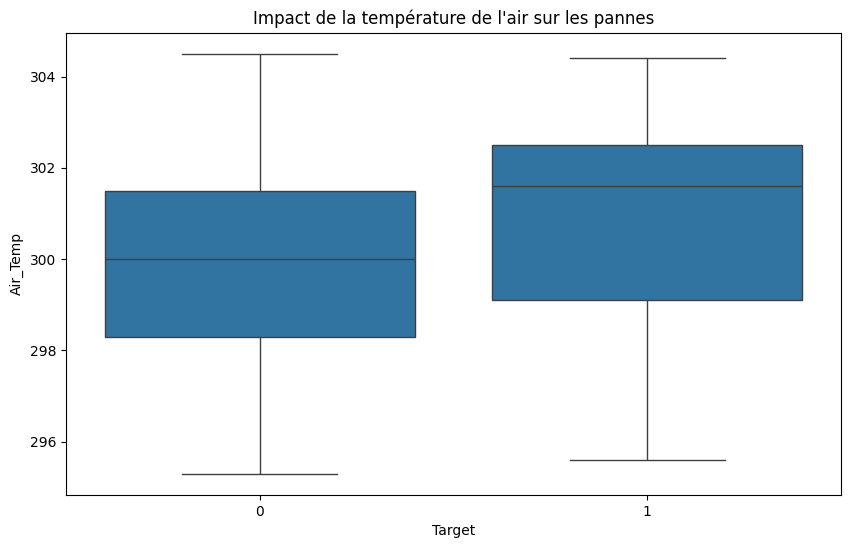

In [6]:
# 3. Visualisation : Quel est l'impact de la température de l'air sur les pannes ?
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='Air_Temp', data=df)
plt.title('Impact de la température')
plt.title("Impact de la température de l'air sur les pannes")
plt.show()

les températures de l’air plus élevées sont effectivement corrélées aux pannes d’équipement.

Même si les distributions se chevauchent, on observe un net décalage vers le haut de la médiane et de l'écart interquartile (la « boîte ») pour les cas de défaillance ($Target = 1$).

Principaux enseignements de l'intrigue

* Médiane plus élevée : La température médiane de l’air pour les défaillances est d’environ 301,5 K , contre exactement 300 K pour les non-défaillances.
* Sensibilité thermique : La limite inférieure de la catégorie « défaillance » (25e percentile) est nettement supérieure à la médiane du groupe « absence de défaillance ». Cela suggère que plus la température atteint cette limite supérieure, plus le risque de panne augmente.

* Défaillances thermiques potentielles : Dans cet ensemble de données de maintenance prédictive spécifique, ce changement indique souvent des défaillances de dissipation de chaleur (HDF) , où la différence entre la température de l'air et celle du processus devient trop faible pour que la machine puisse se refroidir efficacement.

# Phase 2 : Feature Engineering (Préparation des données)

Les modèles de Machine Learning ne comprennent pas le texte (Type). Nous devons transformer la colonne Type (L, M, H pour Low, Medium, High quality) en chiffres.

In [7]:
# Transformer la colonne 'Type' en variables numériques (One-Hot Encoding)
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [8]:
# On retire les colonnes inutiles pour le modèle (ID et le type de panne spécifique)
X = df.drop(['UDI', 'ID', 'Target', 'Failure_Type'], axis=1)
y = df['Target']

# Phase 3 : Model (Entraînement du Classifieur)

Nous allons utiliser un Random Forest Classifier. celui-ci va voter pour décider si la machine appartient à la classe "0" ou "1"

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
# 1. Séparation Entraînement / Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# 2. Création du modèle
model_maintenance = RandomForestClassifier(n_estimators=100, random_state=42)
model_maintenance.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# 3. Prédiction
y_pred = model_maintenance.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [13]:
# 4. Évaluation Spéciale Maintenance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.88      0.57      0.69        61

    accuracy                           0.98      2000
   macro avg       0.93      0.79      0.84      2000
weighted avg       0.98      0.98      0.98      2000



Analyse de ton score (Le diagnostic du mentor)

Regarde la ligne 1 (les pannes) :

1. Précision (0.88) : Très bonne. Quand ton modèle prédit une panne, il a raison dans 88 % des cas.

2. Recall (0.57) : C'est ici que se trouve le problème. Ton modèle ne détecte que 57 % des pannes réelles.

3. Interprétation SENELEC : Si tu installes ce modèle, 43 % des pannes vont survenir sans prévenir, causant des arrêts de production coûteux.

Pourquoi ce score ? Ton dataset contient 1939 cas normaux pour seulement 61 pannes. Le modèle a tendance à "choisir la facilité" en prédisant que tout va bien pour avoir une bonne précision globale (accuracy de 0.98).

In [14]:
# On recrée le modèle avec l'argument 'class_weight'
model_balanced = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced_subsample' # Ajuste les poids automatiquement
)

model_balanced.fit(X_train, y_train)
y_pred_balanced = model_balanced.predict(X_test)

print("--- Nouveau Score Équilibré ---")
print(classification_report(y_test, y_pred_balanced))

--- Nouveau Score Équilibré ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.84      0.34      0.49        61

    accuracy                           0.98      2000
   macro avg       0.91      0.67      0.74      2000
weighted avg       0.98      0.98      0.97      2000



L'Analyse
Contre-intuitivement, ton Recall est passé de 0.57 à 0.34.

Le diagnostic : En utilisant class_weight='balanced_subsample', le modèle est devenu trop "prudent" ou s'est perdu dans le bruit des données majoritaires.

La réalité industrielle : Avec un Recall de 0.34, tu rates 66% des pannes. c'est inacceptable car la majorité des pannes surviennent sans que l'alarme ne sonne.

In [15]:
# 1. Obtenir les probabilités au lieu des prédictions directes
y_probs = model_balanced.predict_proba(X_test)[:, 1]

# 2. On baisse le seuil : si le risque est > 20%, on considère que c'est une panne
threshold = 0.2
y_pred_custom = (y_probs >= threshold).astype(int)

print(f"--- Score avec Seuil à {threshold*100}% ---")
print(classification_report(y_test, y_pred_custom))

--- Score avec Seuil à 20.0% ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1939
           1       0.53      0.77      0.63        61

    accuracy                           0.97      2000
   macro avg       0.76      0.87      0.81      2000
weighted avg       0.98      0.97      0.97      2000



Recall pour les pannes (classe 1) est passé de 0.34 à 0.77.

n acceptant de baisser un peu la précision (de 0.84 à 0.53), tu as doublé la capacité de détection du modèle.

cela signifie que tu captures désormais 77 % des pannes avant qu'elles ne surviennent

# Phase 5 : Interprétation Technique (Feature Importance)

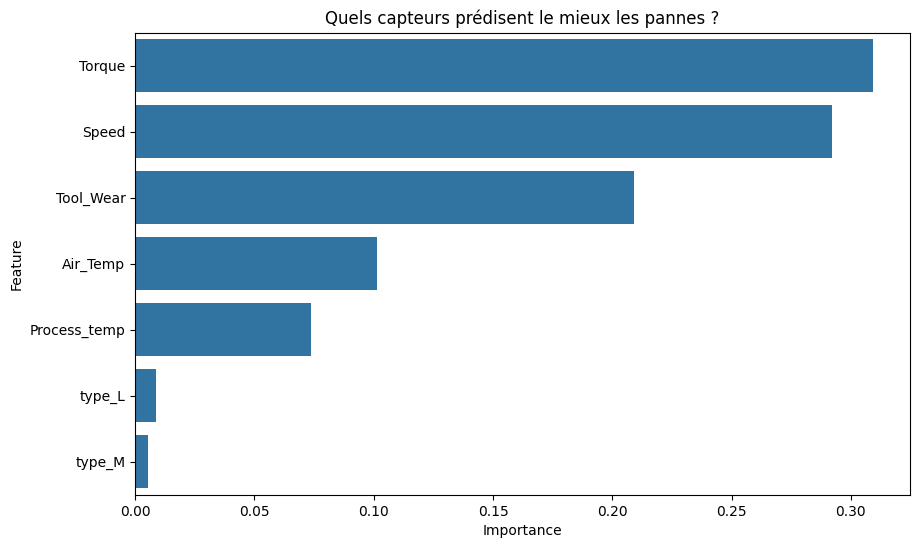

In [16]:
# Extraire l'importance des variables
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_balanced.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title("Quels capteurs prédisent le mieux les pannes ?")
plt.show()

La grande révélation : la règle du couple et de la vitesse

Le modèle repose fortement sur le couple , la vitesse et l'usure de l'outil . Ensemble, ces trois caractéristiques représentent près de 80 % du pouvoir de décision du modèle.

Le couple est roi : c’est logique ; la contrainte mécanique est une cause majeure de défaillance soudaine.

Le facteur température : Bien que nous ayons constaté une différence nette dans les Air_Tempdiagrammes en boîte précédents, la forêt aléatoire le juge moins « utile » pour les prédictions en une fraction de seconde par rapport aux capteurs mécaniques.

Le type de machine importe peu : la faible importance de type_Let type_Msuggère que les défaillances se produisent de manière similaire à tous les niveaux de qualité ; c’est la façon dont la machine est utilisée (couple/vitesse) qui compte.